In [9]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/breast-cancer-wisconsin-diagnostic-dataset/wdbc.names
/kaggle/input/breast-cancer-wisconsin-diagnostic-dataset/wdbc.data


In [10]:
import pandas as pd

# Dataset paths
data_path = "/kaggle/input/breast-cancer-wisconsin-diagnostic-dataset/wdbc.data"
# Column names from the .names file documentation
columns = ['ID','diagnosis'] + [f'feature_{i}' for i in range(1,31)]

# Load CSV
df = pd.read_csv(data_path, names=columns)

# Quick look
print(df.head())
print(df.info())
print(df['diagnosis'].value_counts())


         ID diagnosis  feature_1  feature_2  feature_3  feature_4  feature_5  \
0    842302         M      17.99      10.38     122.80     1001.0    0.11840   
1    842517         M      20.57      17.77     132.90     1326.0    0.08474   
2  84300903         M      19.69      21.25     130.00     1203.0    0.10960   
3  84348301         M      11.42      20.38      77.58      386.1    0.14250   
4  84358402         M      20.29      14.34     135.10     1297.0    0.10030   

   feature_6  feature_7  feature_8  ...  feature_21  feature_22  feature_23  \
0    0.27760     0.3001    0.14710  ...       25.38       17.33      184.60   
1    0.07864     0.0869    0.07017  ...       24.99       23.41      158.80   
2    0.15990     0.1974    0.12790  ...       23.57       25.53      152.50   
3    0.28390     0.2414    0.10520  ...       14.91       26.50       98.87   
4    0.13280     0.1980    0.10430  ...       22.54       16.67      152.20   

   feature_24  feature_25  feature_26  featu

In [11]:
from sklearn.preprocessing import StandardScaler, LabelEncoder

# Features & Target
X = df.drop(columns=['ID','diagnosis'])
y = df['diagnosis']

# Encode target: B=0, M=1
le = LabelEncoder()
y = le.fit_transform(y)

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("Features scaled, target encoded")


Features scaled, target encoded


In [12]:
from sklearn.model_selection import train_test_split

# 80% train, 20% test, stratify to keep class distribution same
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, stratify=y, random_state=42
)

print(f"Training samples: {X_train.shape[0]}, Testing samples: {X_test.shape[0]}")


Training samples: 455, Testing samples: 114


In [13]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, roc_auc_score

# Models dictionary
models = {
    'LogisticRegression': LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42),
    'SVM': SVC(probability=True, class_weight='balanced', random_state=42),
    'RandomForest': RandomForestClassifier(n_estimators=200, class_weight='balanced', random_state=42),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
}

results = {}

for name, model in models.items():
    # Train
    model.fit(X_train, y_train)
    
    # Predict
    y_pred = model.predict(X_test)
    
    # Predict probabilities if available
    y_proba = model.predict_proba(X_test)[:,1] if hasattr(model, "predict_proba") else None
    
    # Metrics
    print(f"\n--- {name} ---")
    print(classification_report(y_test, y_pred))
    if y_proba is not None:
        print("ROC AUC:", roc_auc_score(y_test, y_proba))
    
    # Save results
    results[name] = {'model': model, 'y_pred': y_pred, 'y_proba': y_proba}



--- LogisticRegression ---
              precision    recall  f1-score   support

           0       0.97      0.99      0.98        72
           1       0.98      0.95      0.96        42

    accuracy                           0.97       114
   macro avg       0.97      0.97      0.97       114
weighted avg       0.97      0.97      0.97       114

ROC AUC: 0.9953703703703705

--- SVM ---
              precision    recall  f1-score   support

           0       0.99      0.99      0.99        72
           1       0.98      0.98      0.98        42

    accuracy                           0.98       114
   macro avg       0.98      0.98      0.98       114
weighted avg       0.98      0.98      0.98       114

ROC AUC: 0.9957010582010581

--- RandomForest ---
              precision    recall  f1-score   support

           0       0.95      1.00      0.97        72
           1       1.00      0.90      0.95        42

    accuracy                           0.96       114
   macro 

In [14]:
import joblib

# Choose best model (yahan SVM)
best_model = results['SVM']['model']

# Save model
joblib.dump(best_model, "breast_cancer_svm_model.joblib")
print("Best model saved as breast_cancer_svm_model.joblib")


Best model saved as breast_cancer_svm_model.joblib


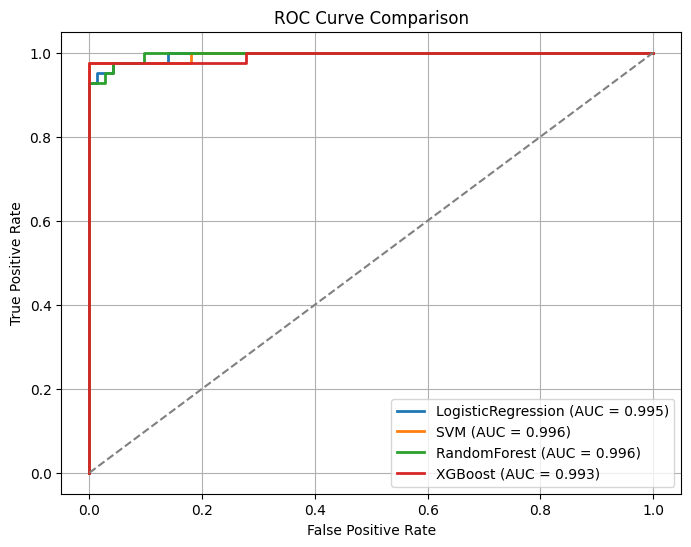

In [15]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

plt.figure(figsize=(8,6))

for name, res in results.items():
    y_proba = res['y_proba']
    if y_proba is not None:
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=2, label=f'{name} (AUC = {roc_auc:.3f})')

plt.plot([0,1],[0,1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


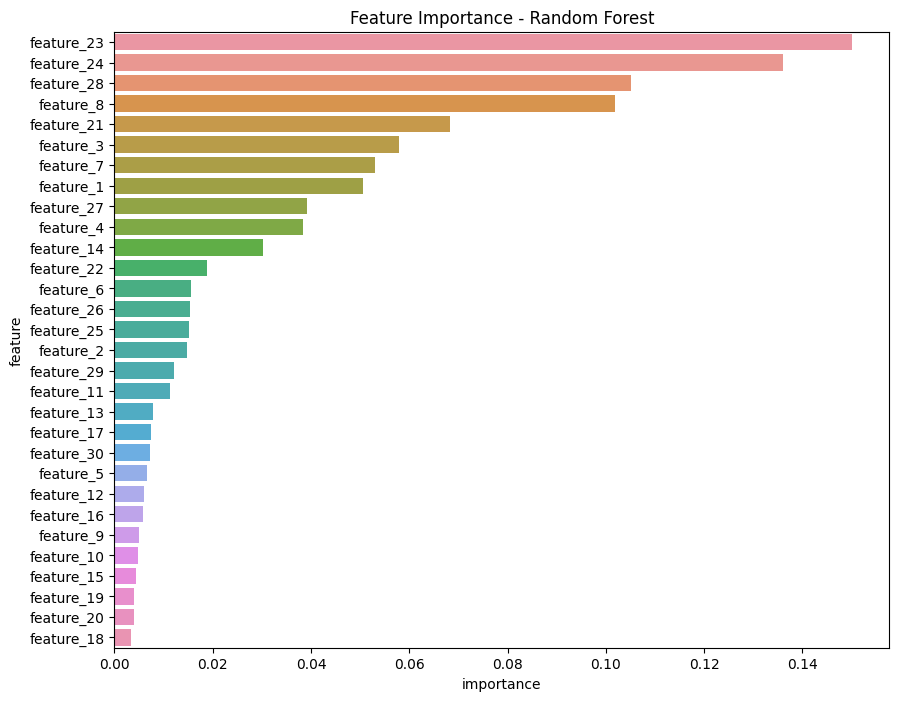

In [16]:
import seaborn as sns
import pandas as pd

# Random Forest feature importance
rf_model = results['RandomForest']['model']
feature_importance = rf_model.feature_importances_

# Create DataFrame
feat_df = pd.DataFrame({
    'feature': df.drop(columns=['ID','diagnosis']).columns,
    'importance': feature_importance
}).sort_values(by='importance', ascending=False)

# Plot
plt.figure(figsize=(10,8))
sns.barplot(x='importance', y='feature', data=feat_df)
plt.title('Feature Importance - Random Forest')
plt.show()
